# GBA1 Hit Validation: Proteome-wide Ranking

This notebook evaluates GBA1 hits by performing link prediction between each small molecule and every protein in the human proteome using the PROTON model. We determine the rank of GBA1 among all possible protein targets to assess specificity/sensitivity.

### Objectives
1. Load PROTON model and pre-trained embeddings.
2. Load new embeddings for GBA1 hits (generated previously).
3. Score each GBA1 hit against ~20,000 proteins.
4. Calculate the rank of GBA1 for each hit.
5. Visualize the rank distribution.

In [1]:
import logging
import os
import sys
import glob
from pathlib import Path
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from rdkit import Chem

# Setup logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
_logger = logging.getLogger(__name__)

# --- Path Setup ---
def _find_repo_root(start: Path) -> Path:
    start = start.resolve()
    for parent in (start, *start.parents):
        if (parent / "pyproject.toml").exists():
            return parent
    return start

PROJECT_ROOT = _find_repo_root(Path.cwd())
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
    
# Change working directory to root for correct config loading
os.chdir(PROJECT_ROOT)

from src.config import conf
from src.constants import TORCH_DEVICE
from src.dataloaders import load_graph
from src.models import HGT

_logger.info(f"Working from: {os.getcwd()}")
_logger.info(f"Device: {TORCH_DEVICE}")

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "sans-serif"

[02/04/26 03:08:53] INFO     Working from: /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM     ]8;id=407629;file:///tmp/ipykernel_810464/3315540517.py\3315540517.py]8;;\:]8;id=618566;file:///tmp/ipykernel_810464/3315540517.py#39\39]8;;\

                    INFO     Device: cuda                                                          ]8;id=566392;file:///tmp/ipykernel_810464/3315540517.py\3315540517.py]8;;\:]8;id=572630;file:///tmp/ipykernel_810464/3315540517.py#40\40]8;;\

In [2]:
# 1. Load Nodes and Edges
_logger.info("Loading graph structure...")
nodes = pd.read_csv(conf.paths.kg.nodes_path, dtype={"node_index": int}, low_memory=False)
edges = pd.read_csv(
    conf.paths.kg.edges_path, 
    dtype={"edge_index": int, "x_index": int, "y_index": int}, 
    low_memory=False
)
kg = load_graph(nodes, edges)

# 2. Load Pretrained Model (for decoder weights)
_logger.info("Loading PROTON model...")
pretrain_model = HGT.load_from_checkpoint(
    checkpoint_path=str(conf.paths.checkpoint.checkpoint_path),
    kg=kg,
    strict=False,
)
pretrain_model.eval()
pretrain_model = pretrain_model.to(TORCH_DEVICE)

# 3. Load Pretrained Embeddings
_logger.info("Loading pretrained embeddings...")
pretrained_embeddings = torch.load(conf.paths.checkpoint.embeddings_path, map_location='cpu')
_logger.info(f"Pretrained embeddings shape: {pretrained_embeddings.shape}")

                    INFO     Loading graph structure...                                             ]8;id=244971;file:///tmp/ipykernel_810464/4014407748.py\4014407748.py]8;;\:]8;id=157717;file:///tmp/ipykernel_810464/4014407748.py#2\2]8;;\

[02/04/26 03:09:24] INFO     Loading PROTON model...                                               ]8;id=992124;file:///tmp/ipykernel_810464/4014407748.py\4014407748.py]8;;\:]8;id=867350;file:///tmp/ipykernel_810464/4014407748.py#12\12]8;;\

[02/04/26 03:09:48] INFO     Loading pretrained embeddings...                                      ]8;id=289484;file:///tmp/ipykernel_810464/4014407748.py\4014407748.py]8;;\:]8;id=276105;file:///tmp/ipykernel_810464/4014407748.py#22\22]8;;\

                    INFO     Pretrained embeddings shape: torch.Size([147020, 512])                ]8;id=809417;file:///tmp/ipykernel_810464/4014407748.py\4014407748.py]8;;\:]8;id=248866;file:///tmp/ipykernel_810464/4014407748.py#24\24]8;;\

In [3]:
# Identify Protein Candidates
# We filter nodes to get only "gene/protein" entities
protein_nodes = nodes[nodes['node_type'] == 'gene/protein'].copy()
protein_indices = torch.tensor(protein_nodes['node_index'].values, dtype=torch.long)
_logger.info(f"Total protein targets in graph: {len(protein_indices)}")

# Find GBA1
target_name = "GBA1"
target_row = protein_nodes[protein_nodes['node_name'] == target_name]

if len(target_row) == 0:
    # Try alternate name if needed, or check substring
    _logger.warning(f"Exact match for {target_name} not found. Searching...")
    target_row = protein_nodes[protein_nodes['node_name'].str.contains(target_name, case=False)]

if len(target_row) > 0:
    gba1_global_idx = target_row.iloc[0]['node_index']
    gba1_name = target_row.iloc[0]['node_name']
    _logger.info(f"Found Target {gba1_name} at Global Index: {gba1_global_idx}")
else:
    raise ValueError(f"Could not find {target_name} in graph nodes.")
    
# Find position of GBA1 within the protein_indices list (for ranking)
gba1_rank_position_idx = (protein_indices == gba1_global_idx).nonzero(as_tuple=True)[0].item()

[02/04/26 03:09:49] INFO     Total protein targets in graph: 35198                                   ]8;id=141940;file:///tmp/ipykernel_810464/459010239.py\459010239.py]8;;\:]8;id=988330;file:///tmp/ipykernel_810464/459010239.py#5\5]8;;\

                    INFO     Found Target GBA1 at Global Index: 1720                                ]8;id=256571;file:///tmp/ipykernel_810464/459010239.py\459010239.py]8;;\:]8;id=51169;file:///tmp/ipykernel_810464/459010239.py#19\19]8;;\

In [4]:
# Load New Drug Embeddings
hits_embeddings_path = PROJECT_ROOT / "notebooks/molecular_analysis/GBA1_hits_embeddings.pt"
hits_metadata_path = PROJECT_ROOT / "data/neurokg/drugs/GBA1_hits_with_embeddings.csv"
drug_smiles_path = PROJECT_ROOT / "data/neurokg/drugs/drug_smiles.csv"

_logger.info(f"Loading hits embeddings from {hits_embeddings_path}")
hits_embeddings = torch.load(hits_embeddings_path, map_location='cpu')

_logger.info(f"Loading metadata from {hits_metadata_path}")
hits_df = pd.read_csv(hits_metadata_path)

if len(hits_embeddings) != len(hits_df):
    _logger.warning(f"Mismatch: {len(hits_embeddings)} embeddings vs {len(hits_df)} metadata rows.")
    # Assuming they align by index if valid
    hits_df = hits_df.iloc[:len(hits_embeddings)]

_logger.info(f"Original Hits shape: {hits_embeddings.shape}")

# --- Filtering Step using InChIKey Overlap ---
_logger.info("Filtering out hits that overlap with existing drugs (using InChIKeys)...")

def get_inchi_key(smiles):
    if not isinstance(smiles, str): return None
    try:
        mol = Chem.MolFromSmiles(smiles)
        return Chem.MolToInchiKey(mol) if mol else None
    except:
        return None

# 1. Load existing drug smiles and get keys
drug_smiles_df = pd.read_csv(drug_smiles_path)
_logger.info(f"Generating InChIKeys for {len(drug_smiles_df)} existing drugs...")
drug_smiles_df['inchi_key'] = drug_smiles_df['SMILES'].apply(get_inchi_key)
existing_keys = set(drug_smiles_df['inchi_key'].dropna().unique())

# 2. Get keys for hits
hits_df['inchi_key'] = hits_df['SMILES'].apply(get_inchi_key)

# 3. Filter
indices_to_keep = []
excluded_count = 0

for idx, row in hits_df.iterrows():
    key = row['inchi_key']
    if key and key in existing_keys:
        excluded_count += 1
    else:
        indices_to_keep.append(idx)

_logger.info(f"Excluded {excluded_count} hits due to overlap.")
_logger.info(f"Retaining {len(indices_to_keep)} hits.")

# Apply filter
hits_df = hits_df.iloc[indices_to_keep].reset_index(drop=True)
hits_embeddings = hits_embeddings[indices_to_keep]

_logger.info(f"Final Filtered Hits shape: {hits_embeddings.shape}")

# Combine Embeddings
# We append the new hits to the end of the pretrained embeddings
combined_embeddings = torch.cat([pretrained_embeddings, hits_embeddings], dim=0)
_logger.info(f"Combined Embeddings Shape: {combined_embeddings.shape}")

# Define indices for the new drugs in the combined tensor
num_pretrained = pretrained_embeddings.shape[0]
new_drug_indices = torch.arange(num_pretrained, num_pretrained + len(hits_embeddings), dtype=torch.long)

                    INFO     Loading hits embeddings from                                            ]8;id=912708;file:///tmp/ipykernel_810464/815549071.py\815549071.py]8;;\:]8;id=69596;file:///tmp/ipykernel_810464/815549071.py#6\6]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/notebooks/molecular               
                             _analysis/GBA1_hits_embeddings.pt                                                     

                    INFO     Loading metadata from                                                   ]8;id=824584;file:///tmp/ipykernel_810464/815549071.py\815549071.py]8;;\:]8;id=861568;file:///tmp/ipykernel_810464/815549071.py#9\9]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/neurokg/drugs/               
                             GBA1_hits_with_embeddings.csv                                                         

                    INFO     Original Hits shape: torch.Size([85, 512])                             ]8;id=736615;file:///tmp/ipykernel_810464/815549071.py\815549071.py]8;;\:]8;id=564669;file:///tmp/ipykernel_810464/815549071.py#17\17]8;;\

                    INFO     Filtering out hits that overlap with existing drugs (using             ]8;id=521842;file:///tmp/ipykernel_810464/815549071.py\815549071.py]8;;\:]8;id=230736;file:///tmp/ipykernel_810464/815549071.py#20\20]8;;\
                             InChIKeys)...                                                                         

                    INFO     Generating InChIKeys for 8160 existing drugs...                        ]8;id=50878;file:///tmp/ipykernel_810464/815549071.py\815549071.py]8;;\:]8;id=693380;file:///tmp/ipykernel_810464/815549071.py#32\32]8;;\

[03:09:53] Explicit valence for atom # 7 Cl, 5, is greater than permitted


[02/04/26 03:09:54] INFO     Excluded 13 hits due to overlap.                                       ]8;id=392611;file:///tmp/ipykernel_810464/815549071.py\815549071.py]8;;\:]8;id=934812;file:///tmp/ipykernel_810464/815549071.py#50\50]8;;\

                    INFO     Retaining 72 hits.                                                     ]8;id=434396;file:///tmp/ipykernel_810464/815549071.py\815549071.py]8;;\:]8;id=629566;file:///tmp/ipykernel_810464/815549071.py#51\51]8;;\

[02/04/26 03:09:55] INFO     Final Filtered Hits shape: torch.Size([72, 512])                       ]8;id=329602;file:///tmp/ipykernel_810464/815549071.py\815549071.py]8;;\:]8;id=484843;file:///tmp/ipykernel_810464/815549071.py#57\57]8;;\

                    INFO     Combined Embeddings Shape: torch.Size([147092, 512])                   ]8;id=460858;file:///tmp/ipykernel_810464/815549071.py\815549071.py]8;;\:]8;id=885746;file:///tmp/ipykernel_810464/815549071.py#62\62]8;;\

In [5]:
# Ranking Analysis Loop
# Edge Type for Drug-Target interactions: (drug, drug_protein, gene/protein)
query_edge_type = ("drug", "drug_protein", "gene/protein")

results = []
protein_count = len(protein_indices)

_logger.info(f"Scoring {len(new_drug_indices)} drugs against {protein_count} proteins...")

for i, drug_global_idx in tqdm(enumerate(new_drug_indices), total=len(new_drug_indices)):
    d_idx = drug_global_idx.item()
    
    # Create batch indices: 1 drug vs All proteins
    batch_src = torch.full((protein_count,), d_idx, dtype=torch.long)
    batch_dst = protein_indices
    
    # Calculate scores
    # We pass use_cache=False and provide the graph since the model usually relies on cache
    # effectively computing sigmoid( (src * W) dot dst )
    with torch.no_grad():
        scores = pretrain_model.get_scores_from_embeddings(
            batch_src, 
            batch_dst, 
            query_edge_type, 
            embeddings=combined_embeddings,
            use_cache=False,
            query_kg=kg
        )
    
    scores_np = scores.cpu().numpy()
    
    # Get GBA1 score
    gba1_score = scores_np[gba1_rank_position_idx]
    
    # Calculate Rank
    # Rank = (count of scores > gba1_score) + 1
    # Higher score = better link
    rank = np.sum(scores_np > gba1_score) + 1
    percentile = (protein_count - rank) / protein_count * 100
    
    # Get Sample Name/ID if available
    sample_name = hits_df.iloc[i].get("Sample Name", f"Hit_{i}")
    smiles = hits_df.iloc[i].get("SMILES", "N/A")
    
    results.append({
        "Hit Index": i,
        "Sample Name": sample_name,
        "SMILES": smiles,
        "GBA1 Score": gba1_score,
        "GBA1 Rank": rank,
        "Percentile": percentile,
        "Top Score": np.max(scores_np),
        "Total Proteins": protein_count
    })

results_df = pd.DataFrame(results)
_logger.info("Scoring complete.")
display(results_df.head())

                    INFO     Scoring 72 drugs against 35198 proteins...                             ]8;id=16850;file:///tmp/ipykernel_810464/2068297166.py\2068297166.py]8;;\:]8;id=744247;file:///tmp/ipykernel_810464/2068297166.py#8\8]8;;\

100%|██████████████████████████| 72/72 [00:06<00:00, 10.76it/s]


[02/04/26 03:10:02] INFO     Scoring complete.                                                     ]8;id=214030;file:///tmp/ipykernel_810464/2068297166.py\2068297166.py]8;;\:]8;id=755229;file:///tmp/ipykernel_810464/2068297166.py#57\57]8;;\

,Hit Index,Sample Name,SMILES,GBA1 Score,GBA1 Rank,Percentile,Top Score,Total Proteins
0,0,NaN,CC(=C)C1CC2=C(O1)C=CC3=C2OCC(C3)C4=C(C=C(C=C4)O)O,0.919359,546,98.448775,0.993547,35198
1,1,NaN,C[C@H]1[C@H]([C@@H]([C@H]([C@H](O1)O[C@H]2CC[C...,0.900962,676,98.079436,0.996094,35198
2,2,NaN,C[C@]12CC[C@@H](CC1=CC[C@@H]3[C@@H]2CC[C@]4([C...,0.940211,547,98.445934,0.994233,35198
3,3,NaN,CC1C(=O)NC(C(=O)N(C(C(=O)NC(C(=O)N(C2CC3=CC=C(...,0.870389,552,98.431729,0.983311,35198
4,4,NaN,CC1=C2CCC(=O)O[C@]2([C@H]3[C@@H](CC1)C(=C)C(=O...,0.857056,789,97.758395,0.996960,35198


In [6]:
# Save Results
output_csv = PROJECT_ROOT / "data/notebooks/molecular_analysis/gba1_ranking_results.csv"
results_df.to_csv(output_csv, index=False)
_logger.info(f"Saved ranking results to {output_csv}")

                    INFO     Saved ranking results to                                               ]8;id=158115;file:///tmp/ipykernel_810464/1465209560.py\1465209560.py]8;;\:]8;id=697124;file:///tmp/ipykernel_810464/1465209560.py#4\4]8;;\
                             /n/holylfs06/LABS/mzitnik_lab/Users/rzhu/PROTON-GEM/data/notebooks/mol                
                             ecular_analysis/gba1_ranking_results.csv                                              

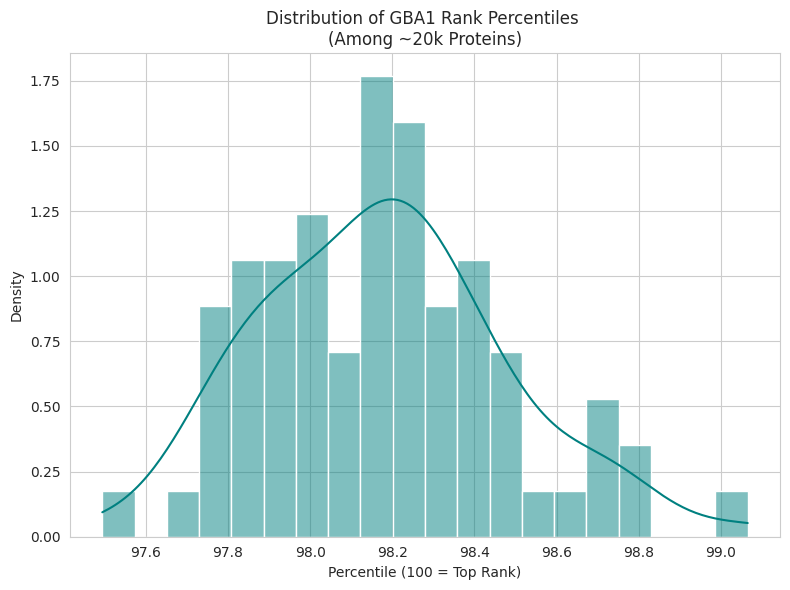

In [12]:
# Visualization: Percentile Distribution (1D)
plt.figure(figsize=(8, 6))

sns.histplot(results_df['Percentile'], bins=20, kde=True, color='teal', stat='density')
plt.title("Distribution of GBA1 Rank Percentiles \n(Among ~20k Proteins)")
plt.xlabel("Percentile (100 = Top Rank)")
plt.ylabel("Density")

plt.tight_layout()
plt.savefig(PROJECT_ROOT / "data/notebooks/molecular_analysis/gba1_percentile_distribution.png")
plt.show()

In [8]:
# Top Hits Analysis
_logger.info("Top 10 Hits where GBA1 is ranked highest:")
top_hits = results_df.sort_values("GBA1 Rank", ascending=True).head(10)
display(top_hits[["Sample Name", "GBA1 Rank", "GBA1 Score", "Top Score", "Percentile"]])

_logger.info("Distribution Stats:")
display(results_df[["GBA1 Rank", "GBA1 Score"]].describe())

[02/04/26 03:10:04] INFO     Top 10 Hits where GBA1 is ranked highest:                              ]8;id=631809;file:///tmp/ipykernel_810464/1859925878.py\1859925878.py]8;;\:]8;id=273418;file:///tmp/ipykernel_810464/1859925878.py#2\2]8;;\

,Sample Name,GBA1 Rank,GBA1 Score,Top Score,Percentile
46,K-Ras(G12C) inhibitor 12,329,0.939350,0.984917,99.065288
65,Poziotinib,429,0.939871,0.987986,98.781181
57,IDH2-C100,433,0.875022,0.973818,98.769816
59,Ravoxertinib,453,0.932684,0.988378,98.712995
27,ML327,455,0.881801,0.980044,98.707313
62,Ro 0437626,462,0.849980,0.967743,98.687425
30,NaN,482,0.903489,0.988278,98.630604
23,Bromosporine,502,0.819857,0.949175,98.573783
56,Toyocamycin,533,0.798398,0.959700,98.485709
13,NaN,533,0.940867,0.995120,98.485709


                    INFO     Distribution Stats:                                                    ]8;id=643793;file:///tmp/ipykernel_810464/1859925878.py\1859925878.py]8;;\:]8;id=655176;file:///tmp/ipykernel_810464/1859925878.py#6\6]8;;\

,GBA1 Rank,GBA1 Score
count,72.000000,72.000000
mean,641.583333,0.889674
std,105.285628,0.041453
min,329.000000,0.776570
25%,577.750000,0.868048
50%,640.000000,0.901331
75%,720.750000,0.920409
max,882.000000,0.940867


Code cell below outputs all edge types in the knowledge graph, used for later reference.

In [9]:
# Output all edge types in the loaded DGL heterograph (kg)

canonical_etypes = list(kg.canonical_etypes)

edge_type_rows = []
for src_type, rel_type, dst_type in canonical_etypes:
    edge_type_rows.append(
        {
            "src_type": src_type,
            "relation": rel_type,
            "dst_type": dst_type,
            "num_edges": int(kg.num_edges((src_type, rel_type, dst_type))),
        }
    )

edge_types_df = pd.DataFrame(edge_type_rows).sort_values(
    ["src_type", "relation", "dst_type"]
).reset_index(drop=True)

print(f"Total canonical edge types: {len(canonical_etypes)}")
display(edge_types_df)

# Optional: raw tuple listing
print("\nCanonical edge types (src, rel, dst):")
for et in canonical_etypes:
    print(et)

Total canonical edge types: 94


,src_type,relation,dst_type,num_edges
0,anatomy,anatomy_anatomy,anatomy,14383
1,anatomy,anatomy_protein_absent,gene/protein,324186
2,anatomy,anatomy_protein_present,gene/protein,3831782
3,anatomy,rev_anatomy_anatomy,anatomy,14383
4,biological_process,bioprocess_bioprocess,biological_process,50232
...,...,...,...,...
89,molecular_function,rev_molfunc_molfunc,molecular_function,13735
90,molecular_function,rev_molfunc_protein,gene/protein,70291
91,pathway,pathway_pathway,pathway,2647
92,pathway,rev_pathway_pathway,pathway,2647



Canonical edge types (src, rel, dst):
('anatomy', 'anatomy_anatomy', 'anatomy')
('anatomy', 'anatomy_protein_absent', 'gene/protein')
('anatomy', 'anatomy_protein_present', 'gene/protein')
('anatomy', 'rev_anatomy_anatomy', 'anatomy')
('biological_process', 'bioprocess_bioprocess', 'biological_process')
('biological_process', 'bioprocess_protein', 'gene/protein')
('biological_process', 'exposure_bioprocess', 'exposure')
('biological_process', 'rev_bioprocess_bioprocess', 'biological_process')
('brain_region', 'region_structure', 'brain_structure')
('brain_structure', 'rev_region_structure', 'brain_region')
('brain_structure', 'structure_cell_type', 'cell_cluster')
('cell_cluster', 'cell_cluster_cell_subcluster', 'cell_subcluster')
('cell_cluster', 'cell_cluster_marker_gene', 'gene/protein')
('cell_cluster', 'cell_type_cell_cluster', 'cell_type')
('cell_cluster', 'rev_structure_cell_type', 'brain_structure')
('cell_subcluster', 'cell_subcluster_marker_gene', 'gene/protein')
('cell_subc

# Combined Ranking Analysis (GBA1 + Disease Indications)

In this section, we evaluate how the GBA1 hits rank against **all other drugs** in the knowledge graph across multiple scoring scenarios. 

We compute rankings efficiently for five scenarios:
1.  **GBA1 Only**: Hits ranked by affinity to GBA1.
2.  **Weighted**: $0.5 \times GBA1 + 0.25 \times Gaucher + 0.25 \times Parkinson$.
3.  **Disease Only**: $0.5 \times Gaucher + 0.5 \times Parkinson$.
4.  **Gaucher Only**.
5.  **Parkinson Only**.

We visualize the results by plotting the score curve of all drugs and marking the position of our candidates.

In [10]:
# 1. Identify All Drug Candidates & Compute Raw Scores
_logger.info("Identifying all drug candidates and scoring...")

# A. Candidates
drug_nodes = nodes[nodes['node_type'] == 'drug']
existing_drug_indices = torch.tensor(drug_nodes['node_index'].values, dtype=torch.long)
all_candidate_drug_indices = torch.cat([existing_drug_indices, new_drug_indices])
_logger.info(f"Total drug candidates: {len(all_candidate_drug_indices)}")

# B. GBA1 Score (Reverse Screening)
reverse_edge_type = ('gene/protein', 'rev_drug_protein', 'drug')
batch_src = torch.full((len(all_candidate_drug_indices),), gba1_global_idx, dtype=torch.long)
with torch.no_grad():
    score_gba1 = pretrain_model.get_scores_from_embeddings(
        batch_src, all_candidate_drug_indices, reverse_edge_type, 
        embeddings=combined_embeddings, use_cache=False, query_kg=kg
    ).cpu().numpy()

# C. Disease Scores (Gaucher & Parkinson)
disease_queries = ["Gaucher disease", "Parkinson disease"]
raw_disease_scores = {}

for query in disease_queries:
    # Find Node
    res = nodes[nodes['node_name'].astype(str).str.contains(query, case=False)]
    if len(res) > 0 and 'disease' in res['node_type'].values:
        d_node = res[res['node_type'] == 'disease'].iloc[0]
        # Specific fix for Parkinson exact match if needed
        if query == "Parkinson disease":
             exact = res[res['node_name'].str.lower() == "parkinson disease"]
             if len(exact) > 0: d_node = exact.iloc[0]
             
        _logger.info(f"Found {query}: {d_node['node_name']} (ID: {d_node['node_index']})")
        
        # Find Edge
        candidates = [et for et in kg.canonical_etypes if et[0] == d_node['node_type'] and et[2] == 'drug']
        if not candidates: continue
        selected_etype = next((et for et in candidates if 'indication' in et[1]), candidates[0])
        
        # Score
        batch_src_d = torch.full((len(all_candidate_drug_indices),), d_node['node_index'], dtype=torch.long)
        with torch.no_grad():
            d_scores = pretrain_model.get_scores_from_embeddings(
                batch_src_d, all_candidate_drug_indices, selected_etype, 
                embeddings=combined_embeddings, use_cache=False, query_kg=kg
            ).cpu().numpy()
        raw_disease_scores[query] = d_scores

_logger.info("Scoring complete.")

                    INFO     Identifying all drug candidates and scoring...                          ]8;id=871370;file:///tmp/ipykernel_810464/975145318.py\975145318.py]8;;\:]8;id=52297;file:///tmp/ipykernel_810464/975145318.py#2\2]8;;\

                    INFO     Total drug candidates: 8232                                             ]8;id=647061;file:///tmp/ipykernel_810464/975145318.py\975145318.py]8;;\:]8;id=981031;file:///tmp/ipykernel_810464/975145318.py#8\8]8;;\

                    INFO     Found Gaucher disease: Gaucher disease type II (ID: 28143)             ]8;id=867738;file:///tmp/ipykernel_810464/975145318.py\975145318.py]8;;\:]8;id=923244;file:///tmp/ipykernel_810464/975145318.py#33\33]8;;\

                    INFO     Found Parkinson disease: Parkinson disease (ID: 39579)                 ]8;id=918260;file:///tmp/ipykernel_810464/975145318.py\975145318.py]8;;\:]8;id=887277;file:///tmp/ipykernel_810464/975145318.py#33\33]8;;\

                    INFO     Scoring complete.                                                      ]8;id=256836;file:///tmp/ipykernel_810464/975145318.py\975145318.py]8;;\:]8;id=735574;file:///tmp/ipykernel_810464/975145318.py#49\49]8;;\

                    INFO     Scenario GBA1 Only - Median Hit Rank: 5390 / 8232                      ]8;id=606728;file:///tmp/ipykernel_810464/821305552.py\821305552.py]8;;\:]8;id=395166;file:///tmp/ipykernel_810464/821305552.py#48\48]8;;\

                    INFO     Scenario Weighted (0.5*GBA1 + 0.25*GD + 0.25*PD) - Median Hit Rank:    ]8;id=32033;file:///tmp/ipykernel_810464/821305552.py\821305552.py]8;;\:]8;id=239436;file:///tmp/ipykernel_810464/821305552.py#48\48]8;;\
                             4786 / 8232                                                                           

                    INFO     Scenario Disease Only (0.5*GD + 0.5*PD) - Median Hit Rank: 3422 / 8232 ]8;id=775457;file:///tmp/ipykernel_810464/821305552.py\821305552.py]8;;\:]8;id=209597;file:///tmp/ipykernel_810464/821305552.py#48\48]8;;\

                    INFO     Scenario Gaucher Only - Median Hit Rank: 3327 / 8232                   ]8;id=618178;file:///tmp/ipykernel_810464/821305552.py\821305552.py]8;;\:]8;id=288562;file:///tmp/ipykernel_810464/821305552.py#48\48]8;;\

                    INFO     Scenario Parkinson Only - Median Hit Rank: 3588 / 8232                 ]8;id=504577;file:///tmp/ipykernel_810464/821305552.py\821305552.py]8;;\:]8;id=98773;file:///tmp/ipykernel_810464/821305552.py#48\48]8;;\

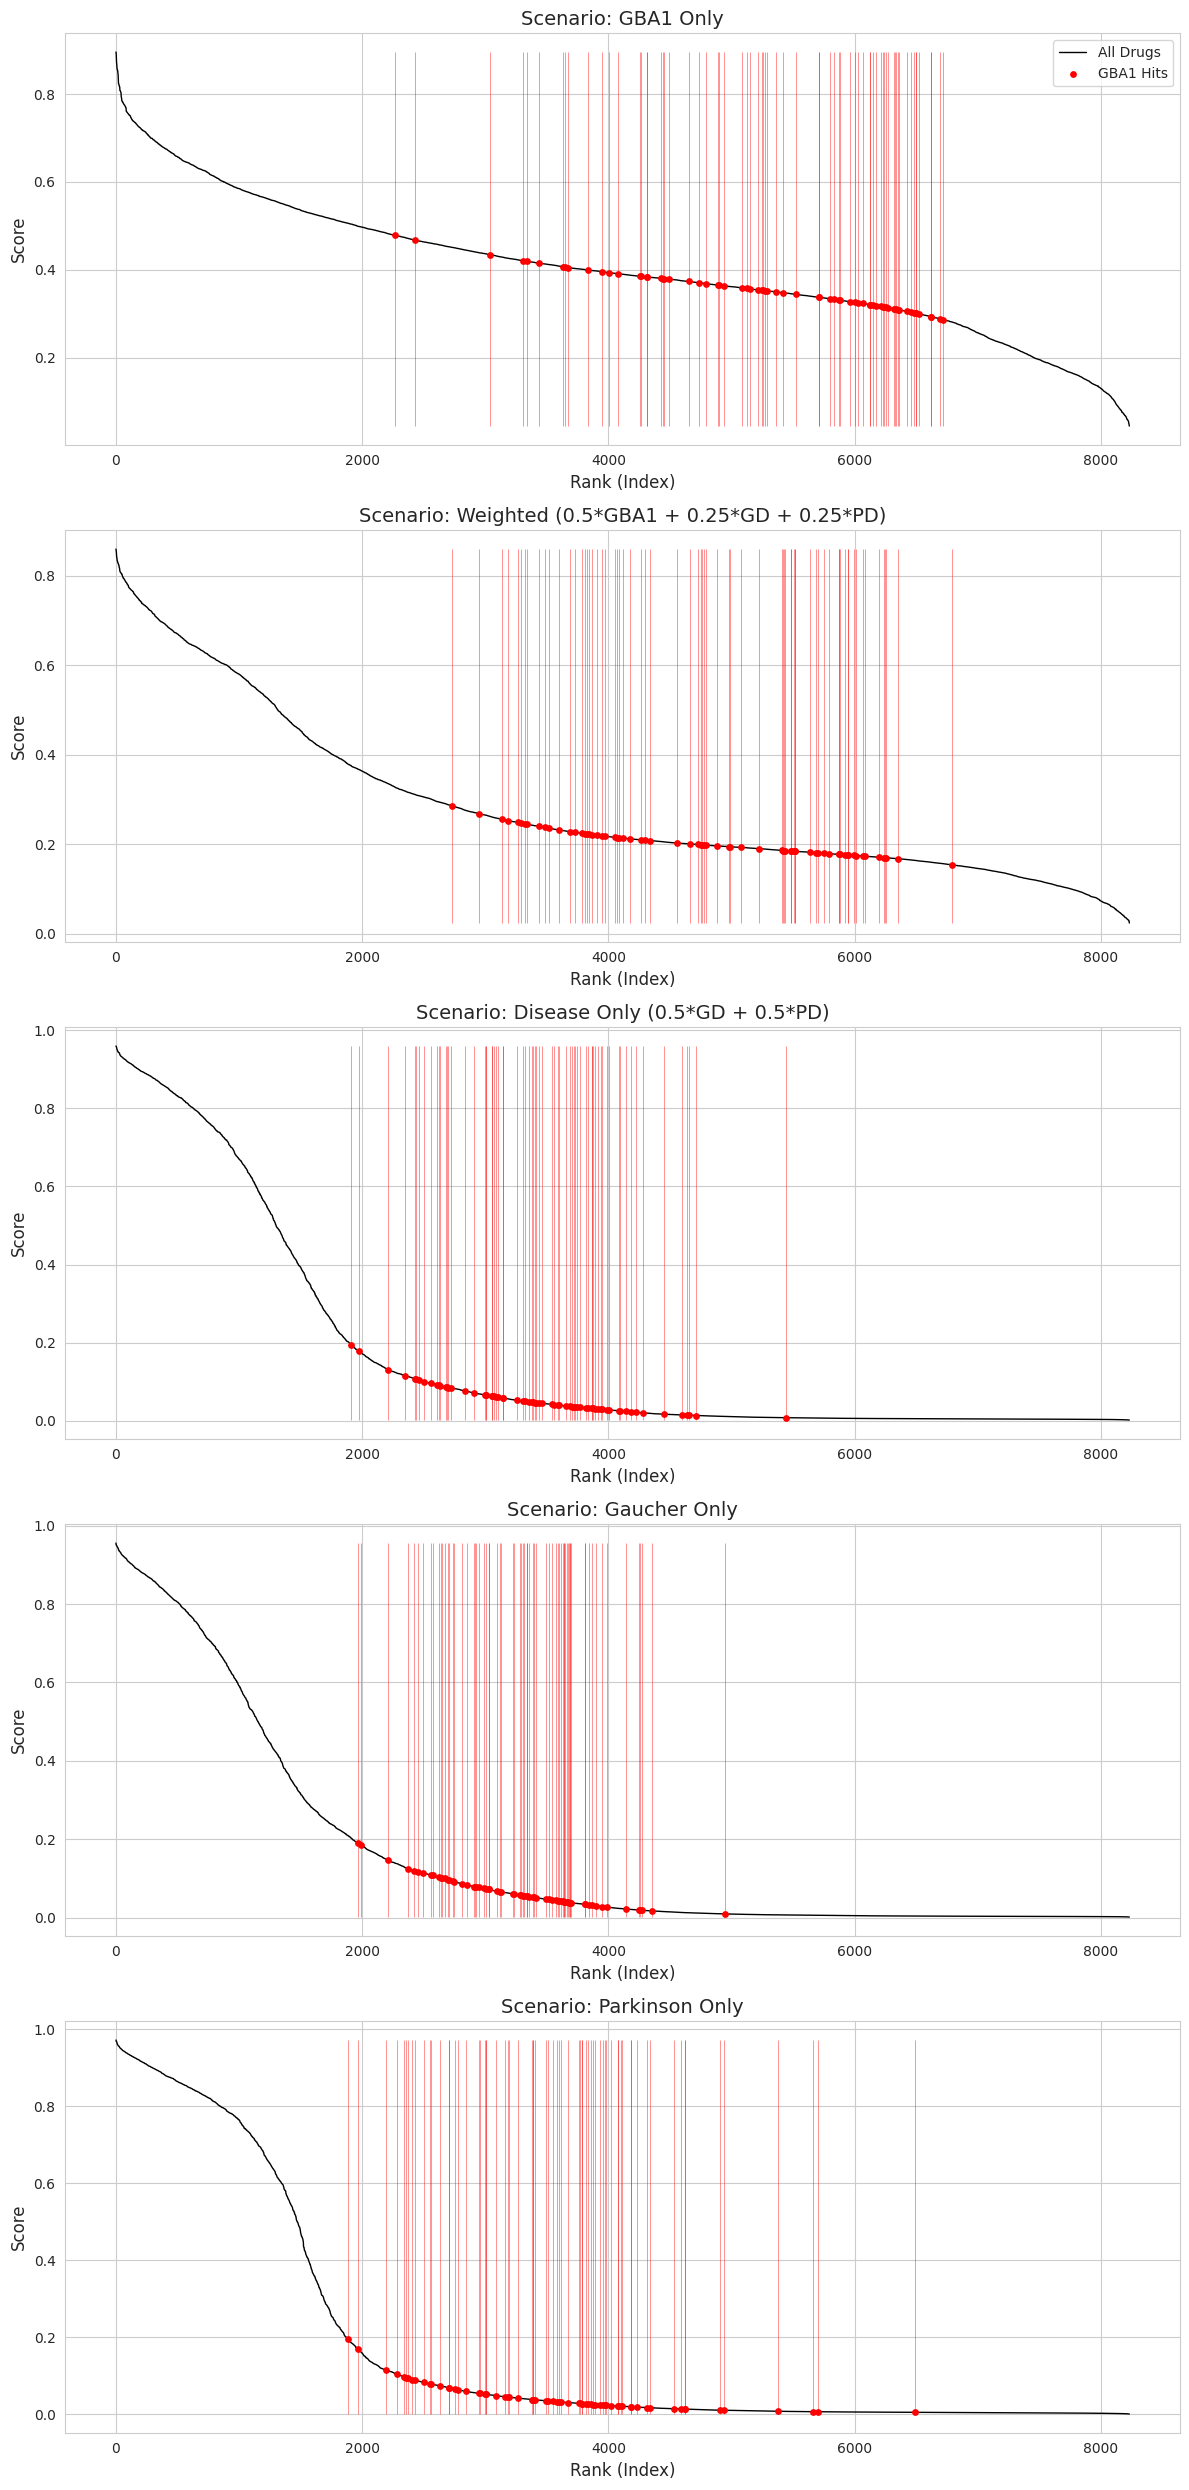

In [11]:
# 2. Scenarios and Visualization
# Clean up missing keys safely
gd_score = raw_disease_scores.get("Gaucher disease", np.zeros_like(score_gba1))
pd_score = raw_disease_scores.get("Parkinson disease", np.zeros_like(score_gba1))

scenarios = {
    "GBA1 Only": score_gba1,
    "Weighted (0.5*GBA1 + 0.25*GD + 0.25*PD)": 0.5 * score_gba1 + 0.25 * gd_score + 0.25 * pd_score,
    "Disease Only (0.5*GD + 0.5*PD)": 0.5 * gd_score + 0.5 * pd_score,
    "Gaucher Only": gd_score,
    "Parkinson Only": pd_score
}

# Where are our hits in the 'all_candidate_drug_indices' array?
# They are appended at the end.
num_existing = len(existing_drug_indices)
hit_indices_local = np.arange(num_existing, len(all_candidate_drug_indices))

# Plotting
fig, axes = plt.subplots(len(scenarios), 1, figsize=(12, 5 * len(scenarios)))
if len(scenarios) == 1: axes = [axes]

for ax, (name, scores) in zip(axes, scenarios.items()):
    # Sort
    sorted_indices = np.argsort(-scores) # Descending
    sorted_scores = scores[sorted_indices]
    
    # Plot Curve
    ax.plot(np.arange(len(sorted_scores)), sorted_scores, color='black', linewidth=1, label='All Drugs')
    
    # Find hits positions
    # Boolean mask of sorted list where item is a hit
    is_hit = np.isin(sorted_indices, hit_indices_local)
    hit_ranks = np.where(is_hit)[0]
    hit_scores = sorted_scores[is_hit]
    
    # Add vertical lines for hits
    ax.vlines(hit_ranks, ymin=min(sorted_scores), ymax=max(sorted_scores), color='red', alpha=0.6, linewidth=0.5)
    # Add scatter for visibility on the line
    ax.scatter(hit_ranks, hit_scores, color='red', s=15, zorder=3, label='GBA1 Hits' if ax == axes[0] else "")
    
    ax.set_title(f"Scenario: {name}", fontsize=14)
    ax.set_xlabel("Rank (Index)", fontsize=12)
    ax.set_ylabel("Score", fontsize=12)
    if ax == axes[0]: ax.legend()
    
    # Print stats
    _logger.info(f"Scenario {name} - Median Hit Rank: {np.median(hit_ranks):.0f} / {len(scores)}")

plt.tight_layout()
plt.savefig(PROJECT_ROOT / "data/notebooks/molecular_analysis/gba1_scenarios_rank_curves.png")
plt.show()